In [1]:
import pandas as pd 
from Bio import SeqIO
#handle fasta files
from Bio import SeqIO
#handle alignment
from Bio import AlignIO
from Bio.Align import AlignInfo
from collections import Counter 
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns
import re
from ete3 import Tree, PhyloTree

from scipy.sparse import lil_matrix
from scipy import sparse
from scipy.sparse.linalg import spsolve

from numpy.linalg import solve, norm

from numpy.random import rand
#from adjustText import adjust_text

In [3]:
path_local = "U:/users/mamorel/Projet_Convergence/condor-analysis/"

In [4]:
positions_besnard = [505,540,572,573,623,665,731,749,751,761,780,839]
Besnard = ["623D", "731V", "505L", "751F", "761A", "749T", "573N", "839K", "540T", "780S", "572Q", "665N"]

## Detections

In [5]:
all_substitutions = pd.read_csv(
        path_local
        + "results/c3c4/condor/tested_results.tsv",
        sep="\t",
    )


#### phenotype uncertainty

In [30]:
all_substitutions_noc3c4 = pd.read_csv(
        path_local
        + "results/c3c4/condor/pheno_noc3c4/tested_results.tsv",
        sep="\t",
    )

### Add FADE

In [6]:
FADE_c3c4 = pd.read_csv(path_local+"results/c3c4/FADE/datamonkey-table_JTTFADE.csv", sep=",")

FADE_c3c4.columns = ["mut","position","rate", "bias", "proba", "BF", "composition", "substitutions"]
FADE_c3c4["posmut"] = FADE_c3c4["position"].astype(str)+FADE_c3c4["mut"]

all_substitutions["posmut"] = [
"".join([str(i), j]) for i, j in zip(all_substitutions.position, all_substitutions.mut)
]

All_bayes_Fade = pd.merge(all_substitutions, FADE_c3c4, on=["posmut", "position", "mut"], how = "left")

#### pheno uncertainty

In [31]:
FADE_noc3c4 = pd.read_csv(path_local+"results/c3c4/FADE/datamonkey-table_noc3c4.csv", sep=",")

FADE_noc3c4.columns = ["mut","position","rate", "bias", "proba", "BF", "composition", "substitutions"]
FADE_noc3c4["posmut"] = FADE_noc3c4["position"].astype(str)+FADE_noc3c4["mut"]

all_substitutions_noc3c4["posmut"] = [
"".join([str(i), j]) for i, j in zip(all_substitutions_noc3c4.position, all_substitutions_noc3c4.mut)
]

All_bayes_Fade_noc3c4 = pd.merge(all_substitutions_noc3c4, FADE_noc3c4, on=["posmut", "position", "mut"], how = "left")

### Add PCOC

In [8]:
pcoc_results_all = pd.read_csv(path_local+"results/c3c4/PCOC/pastml_pcoc/cyp_coding.aa.coor_mays.results.tsv", sep="\t")
subset_pcoc_results = pd.DataFrame(pcoc_results_all[pcoc_results_all.Sites.isin(all_substitutions.position)])
subset_pcoc_results.rename(columns={"Sites": "position"}, inplace = True)
All_bayes_fade_pcoc = pd.merge(All_bayes_Fade, subset_pcoc_results , on="position")

#### pheno uncertainty

In [33]:
pcoc_results_all_noc3c4 = pd.read_csv(path_local+"results/c3c4/PCOC/cyp_coding_noc3c4.aa.coor_mays.results.tsv", sep="\t")
subset_pcoc_results_noc3c4 = pd.DataFrame(pcoc_results_all_noc3c4[pcoc_results_all_noc3c4.Sites.isin(all_substitutions_noc3c4.position)])
subset_pcoc_results_noc3c4.rename(columns={"Sites": "position"}, inplace = True)
All_bayes_fade_pcoc_noc3c4 = pd.merge(All_bayes_Fade_noc3c4, subset_pcoc_results_noc3c4 , on="position")

### Analysis

In [10]:
methods_detect = []
#criterion bf : BF >= 2 & c == "positive"
#criterion condor : p <= 0.1
#criterion pcoc : PC > 0.8 & c == "positive"
#criterion condorBT : p <= 0.1 & BF >= 2 & c == "positive"

for p,bf,c,oc,pc, fade in  zip(All_bayes_fade_pcoc["adjust_pvalue"], All_bayes_fade_pcoc["BF_x"] , All_bayes_fade_pcoc["correlation"], All_bayes_fade_pcoc["OC"], All_bayes_fade_pcoc["PC"], All_bayes_fade_pcoc["BF_y"]) : 
    if (p <= 0.1) and (bf >= 2) and (c == "positive"):
        methods_detect.append("condorBT")
    elif (c == "positive") and (pc > 0.8):
        methods_detect.append("Pcoc_pos")
    elif (c == "positive") and (oc > 0.8):
        methods_detect.append("Pcoc_pos")
    elif (pc > 0.8):
        methods_detect.append("pcoc")
    elif (oc > 0.8):
        methods_detect.append("pcoc")
    elif fade > 0:
        methods_detect.append("fade")
    elif (bf >= 2) and (c == "positive"):
        methods_detect.append("BayesTraits")
    elif p <= 0.1:
        methods_detect.append("condor")
    else:
        methods_detect.append("none")

All_bayes_fade_pcoc["method"] = methods_detect


In [35]:
methods_detect_noc3c4 = []
#criterion bf : BF >= 2 & c == "positive"
#criterion condor : p <= 0.1
#criterion pcoc : PC > 0.8 & c == "positive"
#criterion condorBT : p <= 0.1 & BF >= 2 & c == "positive"

for p,bf,c,oc,pc, fade in  zip(All_bayes_fade_pcoc_noc3c4["adjust_pvalue"], All_bayes_fade_pcoc_noc3c4["BF_x"] , All_bayes_fade_pcoc_noc3c4["correlation"], All_bayes_fade_pcoc_noc3c4["OC"], All_bayes_fade_pcoc_noc3c4["PC"], All_bayes_fade_pcoc_noc3c4["BF_y"]) : 
    if (p <= 0.1) and (bf >= 2) and (c == "positive"):
        methods_detect_noc3c4.append("condorBT")
    elif (c == "positive") and (pc > 0.8):
        methods_detect_noc3c4.append("Pcoc_pos")
    elif (c == "positive") and (oc > 0.8):
        methods_detect_noc3c4.append("Pcoc_pos")
    elif (pc > 0.8):
        methods_detect_noc3c4.append("pcoc")
    elif (oc > 0.8):
        methods_detect_noc3c4.append("pcoc")
    elif fade > 0:
        methods_detect_noc3c4.append("fade")
    elif (bf >= 2) and (c == "positive"):
        methods_detect_noc3c4.append("BayesTraits")
    elif p <= 0.1:
        methods_detect_noc3c4.append("condor")
    else:
        methods_detect_noc3c4.append("none")

All_bayes_fade_pcoc_noc3c4["method"] = methods_detect_noc3c4


In [11]:
classification = []
risk = 0.1

for det, anc, pos, mut in zip(All_bayes_fade_pcoc.method, All_bayes_fade_pcoc.pastml_root, All_bayes_fade_pcoc.position, All_bayes_fade_pcoc.mut ):
    if det == "condorBT":
        if pos in positions_besnard:
            classification.append("Detected Besnard")
        else: 
            classification.append("ConDor convergent candidate")
    else:
        if pos in positions_besnard:
            classification.append("Not detected Besnard")
        else: 
            classification.append("Random mutation")


All_bayes_fade_pcoc["classification"] = classification

In [36]:
classification_noc3c4 = []
risk = 0.1

for det, anc, pos, mut in zip(All_bayes_fade_pcoc_noc3c4.method, All_bayes_fade_pcoc_noc3c4.pastml_root, All_bayes_fade_pcoc_noc3c4.position, All_bayes_fade_pcoc_noc3c4.mut ):
    if det == "condorBT":
        if pos in positions_besnard:
            classification_noc3c4.append("Detected Besnard")
        else: 
            classification_noc3c4.append("ConDor convergent candidate")
    else:
        if pos in positions_besnard:
            classification_noc3c4.append("Not detected Besnard")
        else: 
            classification_noc3c4.append("Random mutation")


All_bayes_fade_pcoc_noc3c4["classification"] = classification_noc3c4

### Results per positions

In [37]:
All_bayes_fade_pcoc_pos = All_bayes_fade_pcoc.sort_values(by = ["position", "pvalue_raw"]).groupby("position").first()
All_bayes_fade_pcoc_pos_noc3c4 = All_bayes_fade_pcoc_noc3c4.sort_values(by = ["position", "pvalue_raw"]).groupby("position").first()

In [45]:
TP = 0
FP = 0   

def table_1_condor(df, method):
    if method == "pc":
        dataset = df[(df.PC >= 0.8) & (df.correlation == "positive") ]  
    elif method == "oc":
        dataset = df[(df.OC >= 0.8) & (df.correlation == "positive") ]  
    elif method == "pcoc":
        dataset = df[(df.PCOC >= 0.8) & (df.correlation == "positive") ]  
    elif method == "FADE":
    #FADE
        dataset = df[(df.BF_y >= 100)] 
    elif method == "FADE_inf":
        dataset = df[(df.BF_y > 1e16)] 
    #emergence
    elif method == "emergence":
        dataset = df[(df.adjust_pvalue <= 0.1) ]  
    elif method == "correlation":
    #correlation
        dataset = df[(df.BF_x >= 2) & (df.correlation == "positive")]
    #condor
    else: 
        dataset = df[(df.BF_x >= 2) & (df.correlation == "positive") & (df.adjust_pvalue <= 0.1)]  
    results = dict(Counter(dataset.classification))
    #TP = results["Detected DRM"]
    TP = len(dataset[dataset.index.isin(positions_besnard)])
    ALL = len(df)
    P = len(df[df.classification.isin(["Detected Besnard", "Not detected Besnard"])])
    N = len(df[~df.classification.isin(["Detected Besnard", "Not detected Besnard"])])
    PP = len(dataset)
    FN = P - TP
    FP = PP-TP
    TN = ALL-PP-FN
    Recall = TP/P
    Precision = TP/PP
    #F1 = 2*(Precision*Recall)/(Precision+Recall)
    F1bis = TP/(TP+((1/2)*(FP+FN)))
    TPR = Recall
    TNR = TN/N
    bal_acc = (TPR + TNR)/2 
    print([np.round(i,2) for i in [TP, FP, FN, TN, Recall, Precision,  F1bis]])


for method in ["pc", "oc", "pcoc", "FADE", "emergence", "correlation", "condor"]:
    print(method)
    table_1_condor(All_bayes_fade_pcoc_pos, method)


for method in ["pc", "oc", "FADE", "emergence", "correlation", "condor"]:
    print(method)
    table_1_condor(All_bayes_fade_pcoc_pos_noc3c4, method)

pc
[1, 4, 11, 40, 0.08, 0.2, 0.12]
oc
[8, 6, 4, 38, 0.67, 0.57, 0.62]
pcoc
[7, 3, 5, 41, 0.58, 0.7, 0.64]
FADE
[11, 4, 1, 40, 0.92, 0.73, 0.81]
emergence
[7, 14, 5, 30, 0.58, 0.33, 0.42]
correlation
[7, 6, 5, 38, 0.58, 0.54, 0.56]
condor
[4, 3, 8, 41, 0.33, 0.57, 0.42]
pc
[0, 3, 11, 37, 0.0, 0.0, 0.0]
oc
[0, 1, 11, 39, 0.0, 0.0, 0.0]
FADE
[8, 9, 3, 31, 0.73, 0.47, 0.57]
emergence
[6, 17, 5, 23, 0.55, 0.26, 0.35]
correlation
[5, 7, 6, 33, 0.45, 0.42, 0.43]
condor
[4, 3, 7, 37, 0.36, 0.57, 0.44]


## Figure 3

In [22]:
pal = sns.color_palette("Greys", 8)
print(pal.as_hex())

sns.color_palette("Greys", 8)


['#f2f2f2', '#dfdfdf', '#c6c6c6', '#a8a8a8', '#868686', '#686868', '#474747', '#212121']


[(0.9483275663206459, 0.9483275663206459, 0.9483275663206459),
 (0.8729104190695887, 0.8729104190695887, 0.8729104190695887),
 (0.7777777777777778, 0.7777777777777778, 0.7777777777777778),
 (0.6578085351787775, 0.6578085351787775, 0.6578085351787775),
 (0.5257977700884275, 0.5257977700884275, 0.5257977700884275),
 (0.40784313725490196, 0.40784313725490196, 0.40784313725490196),
 (0.27866205305651676, 0.27866205305651676, 0.27866205305651676),
 (0.12745866974240677, 0.12745866974240677, 0.12745866974240677)]

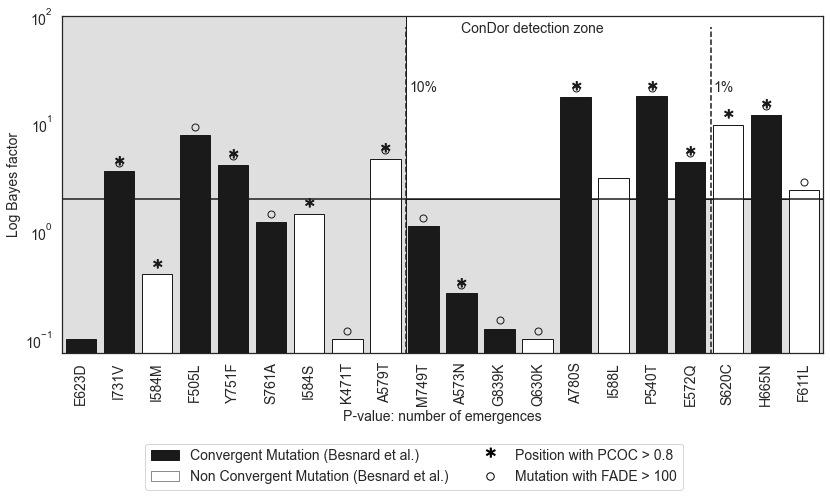

In [27]:
pos_mut_interest = set()

All_bayes_fade_pcoc["BF_graph"] = [i if (i > 0) and (j == "positive") else 0.1 for i,j in zip(All_bayes_fade_pcoc.BF_x, All_bayes_fade_pcoc.correlation)]

pcoc_detections = set(All_bayes_fade_pcoc[(All_bayes_fade_pcoc.PCOC > 0.8) & (All_bayes_fade_pcoc.correlation == "positive")].posmut)
besnard_det = set(All_bayes_fade_pcoc[All_bayes_fade_pcoc.classification.isin(["Detected Besnard", "Not detected Besnard"])].posmut)
condor_det = set(All_bayes_fade_pcoc[All_bayes_fade_pcoc.method == "condorBT"].posmut)
fade_det = set(All_bayes_fade_pcoc[ All_bayes_fade_pcoc.BF_y > 100 ].posmut)

pos_mut_interest.update(pcoc_detections)
pos_mut_interest.update(besnard_det)
pos_mut_interest.update(condor_det)
pos_mut_interest.update(fade_det)

dataset = pd.DataFrame(All_bayes_fade_pcoc[All_bayes_fade_pcoc.posmut.isin(pos_mut_interest)])
sorted_dataset = dataset.sort_values("pvalue_raw" , axis=0, ascending=False)

sns.set(style = "white")
sns.set_context("notebook", rc={"lines.linewidth": 1.5})

f,ax= plt.subplots(1,1, figsize=(11.69, 7.27))

font = 14

width = 0.75
x = np.arange(len(sorted_dataset))


############figure#####################

##color 
col_list=[]

for i,j,k,l in zip(sorted_dataset.position, sorted_dataset.BF_x, sorted_dataset.classification, sorted_dataset.PCOC):
    if k == "Detected Besnard":
        col_list.append("k") #black
    elif k == "Not detected Besnard":
        col_list.append("k") #white
    elif (l > 0.8):
        col_list.append("w")
    else:
        col_list.append("w")


pcoc = []
for pc, b, oc in zip(sorted_dataset.PC, sorted_dataset.PCOC, sorted_dataset.OC):
    if (oc > 0.8) & (b > 0.8): 
        pcoc.append("$*$")
    else:
        pcoc.append("")


fade = []
for bf in sorted_dataset.BF_y:
    if bf > 100:
        fade.append(".")
    else:
        fade.append("")

sns.barplot(data = sorted_dataset, x = "posmut", y = "BF_graph", palette = col_list)

##lim pvalues
lim1 = len(sorted_dataset[sorted_dataset.adjust_pvalue >= 0.01])
lim10 = len(sorted_dataset[sorted_dataset.adjust_pvalue >= 0.1])
lim50 = len(sorted_dataset[sorted_dataset.adjust_pvalue >= 0.5])

ax.axhline(2 , color = 'k')

ax.vlines(ymin = 0, ymax = 80, x = lim1-width*0.6 , colors = 'k', linestyles = '--')
ax.vlines(ymin =0, ymax =80, x= lim10-width*0.6 , colors = 'k', linestyles = '--')

ax.text(s = "1%", x = lim1-width/2 , y = 20 , fontsize=14)
ax.text(s = "10%", x = lim10-width/2, y = 20 , fontsize=14)

plt.axhspan(0, 2, facecolor=pal[1], alpha=1, zorder=-100)
plt.axvspan(-1.1, lim10-width*0.6, facecolor=pal[1], alpha=1, zorder=-100)

ax.text(s = "ConDor detection zone", x = 10, y = 70 , fontsize=14)

for i, patch in enumerate(ax.patches):
        patch.set_edgecolor('k')

pop_a = mpatches.Patch(color='k', label='Convergent Mutation (Besnard et al.)')
pop_b = mpatches.Patch(color='w', label='Non Convergent Mutation (Besnard et al.)', linewidth = 0.5)
stars = mlines.Line2D([], [], marker='$*$', linestyle='None',
                          markersize=15, label='Position with PCOC > 0.8', color='black',
                          fillstyle= 'full')

circle = mlines.Line2D([], [], marker='.', linestyle="None",
                          markersize=15, label='Mutation with FADE > 100', color='black',
                          fillstyle= 'none')
pop_b.set_edgecolor("k")


ax.legend(handles=[pop_a, pop_b, stars, circle], loc= "upper left", fontsize = 14, bbox_to_anchor=(0.1, -0.25), ncol = 2 )

ax.set_xticks(x) 
ax.margins(x=0.02) 

ax.set_ylabel("Log Bayes factor", fontsize = font)
ax.set_xlabel("P-value: number of emergences", fontsize = font)

plt.yscale('log')
plt.ylim(0.075, 100)
plt.xlim(-0.5, 19.5)


for a, b, c in zip(x, sorted_dataset.BF_graph.values, pcoc):
    ax.plot(a, b+0.2*b, marker = c, color = "k", fillstyle= 'full', markersize=14)

for a, b, c in zip(x, sorted_dataset.BF_graph.values, fade):
    ax.plot(a, b+0.2*b, marker = c, color = "k", fillstyle= 'none', markersize=14)


label_xticks = ["".join([i,str(j), k]) for i,j,k in zip(sorted_dataset.max_anc, sorted_dataset.position, sorted_dataset.mut)]


_= plt.setp( ax, xticklabels = label_xticks)
_= plt.setp( ax.xaxis.get_majorticklabels(), rotation=90, fontsize = font)
_= plt.setp( ax.yaxis.get_majorticklabels(), fontsize = font)

plt.tight_layout()


## Change phenotype

In [28]:
all_substitutions = pd.read_csv(
        path_local
        + "results/c3c4/condor/pheno_noc3c4/tested_results.tsv",
        sep="\t",
    )



In [ ]:
FADE_c3c4 = pd.read_csv(path_local+"results/c3c4/FADE/datamonkey-table_JTTFADE.csv", sep=",")

FADE_c3c4.columns = ["mut","position","rate", "bias", "proba", "BF", "composition", "substitutions"]
FADE_c3c4["posmut"] = FADE_c3c4["position"].astype(str)+FADE_c3c4["mut"]

all_substitutions["posmut"] = [
"".join([str(i), j]) for i, j in zip(all_substitutions.position, all_substitutions.mut)
]

All_bayes_Fade = pd.merge(all_substitutions, FADE_c3c4, on=["posmut", "position", "mut"], how = "left")

In [ ]:
pcoc_results_all = pd.read_csv(path_local+"results/c3c4/PCOC/pastml_pcoc/cyp_coding.aa.coor_mays.results.tsv", sep="\t")
subset_pcoc_results = pd.DataFrame(pcoc_results_all[pcoc_results_all.Sites.isin(all_substitutions.position)])
subset_pcoc_results.rename(columns={"Sites": "position"}, inplace = True)
All_bayes_fade_pcoc = pd.merge(All_bayes_Fade, subset_pcoc_results , on="position")